In [1]:
import argparse
import time
import torch
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.logging import log
import easydict
import rdkit
from rdkit import Chem
import torch_geometric
import torch_geometric.utils.smiles as smiles
import random
import numpy as np
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import community as community_louvain
import matplotlib.cm as cm
import os

In [2]:
parser = argparse.ArgumentParser()
args = easydict.EasyDict({
    "dataset": 'MUTAG',
    "batch_size": 128,
    "hidden_channels": 32,
    "lr": 0.0005,
    "epochs": 2000,
})

In [3]:
dataset = TUDataset(root='./mutag_data', name=args.dataset).shuffle()
dataset

MUTAG(188)

In [4]:
torch.unique(dataset.y)

tensor([0, 1])

In [5]:
train_loader = DataLoader(dataset[:0.9], args.batch_size, shuffle=True)
test_loader = DataLoader(dataset[0.9:], args.batch_size)

In [6]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, args.hidden_channels)
        self.conv2 = GCNConv(args.hidden_channels, args.hidden_channels)
        self.conv3 = GCNConv(args.hidden_channels, args.hidden_channels)
        self.lin = Linear(args.hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.lin(x)

        return x

def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = F.cross_entropy(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
    return total_loss / len(train_loader.dataset)


@torch.no_grad()
def test(loader):
    model.eval()

    total_correct = 0
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=-1)
        
        total_correct += int((pred == data.y).sum())
    return total_correct / len(loader.dataset)

In [7]:
def evaluate_gnn(graph):
    with torch.no_grad():
        model.eval()
        graph = graph.to(device)
        # The pred is not used for accuracy, the softmax is used
        out = model(graph.x.float(), graph.edge_index, graph.batch)
        pred = out.argmax(dim=-1)

        # Getting class prediction probabilities from the softmax layer
        softmax = out.softmax(dim=-1)

        return softmax.tolist()

In [8]:
softmax_dict_list = []
max_pred_list = []
avg_max_pred_list = []
class_smile_list = []
class_graph_list = []
graph_dict_list = []

In [9]:
def get_max_pred(softmax_dict,i):
    prob_class0_dict = {}
    prob_class1_dict = {}
    
    for graph in softmax_dict:
        if len(softmax_dict[graph]) > 0:
            list0 = []
            list1 = []
    
            for prob in softmax_dict[graph]:
                list0.append(prob[0])
                list1.append(prob[1])
    
        #Taking max probability of all nodes of each class in a graph
        if len(list0) != 0:
            prob_class0_dict[graph] = max(list0)
        if len(list1) != 0:
            prob_class1_dict[graph] = max(list1)
    
    max_pred0 = max(prob_class0_dict.values())
    max_pred1 = max(prob_class1_dict.values())

    print('Run'+str(i), max_pred0, max_pred1)
    max_pred_list.append([max_pred0, max_pred1])
    
    avg_max_pred = (max_pred0+max_pred1)/2
    avg_max_pred_list.append(avg_max_pred)
    
    graph_dict_list.append(graph_dict)
    #print(graph_dict)
    softmax_dict_list.append(softmax_dict)

    class0_smile = max(prob_class0_dict, key=prob_class0_dict.get)
    class1_smile = max(prob_class1_dict, key=prob_class1_dict.get)

    class_smile_list.append([class0_smile,class1_smile])
    
    class_graph_list.append([graph_dict.get(class0_smile), graph_dict.get(class1_smile)])

In [10]:
concatenate text files for different sizes
filenames = ['smiles_txt/final_smiles_11.txt', 'smiles_txt/final_smiles_12.txt', 'smiles_txt/final_smiles_13.txt', 
             'smiles_txt/final_smiles_14.txt', 'smiles_txt/final_smiles_15.txt']
with open('smiles_txt/final_smiles.txt', 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                outfile.write(line)


In [11]:
#['C', 'N', 'O', 'F', 'I', 'Cl', 'Br']
atomic_numbers = {0: 6, 1: 7, 2: 8, 3: 9, 4: 53, 5: 17, 6: 35}
edge_types = {0: 'AROMATIC', 1: 'SINGLE', 2: 'DOUBLE', 3: 'TRIPLE'}


for i in range(0,10):
    
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    
    model = GCN(hidden_channels=args.hidden_channels).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
    criterion = torch.nn.CrossEntropyLoss()
    

    best_test_acc = 0
    start_patience = patience = 100
    for epoch in range(1, args.epochs + 1):
        loss = train()
        train_acc = test(train_loader)
        test_acc = test(test_loader)
        if epoch % 200 == 0:
            log(Epoch=epoch, Loss=loss, Train=train_acc, Test=test_acc)
        if best_test_acc <= test_acc:
            patience = start_patience
            best_test_acc = test_acc
        else:
            patience -= 1
    
        if patience <= 0:
            print('Stopping training as validation accuracy did not improve '
                  f'for {start_patience} epochs')
            break


    
    counter = 0
    f = open('../../graph generator/diffusion models/sampled_graphs_diffusion/mutag/final_smiles.txt', 'r')
    list_smiles = []
    unique_labels = [0, 1]
    softmax_dict = {}
    graph_dict = {}
    counter = 0
    for l in f:
        
        if l != 'None\n':
            #counter=counter+1
            list_smiles.append(l)
            #print(l)
            counter = counter + 1
            graph = smiles.from_smiles(l)
            mol = Chem.MolFromSmiles(l)
    
            node_type_list = []
            for atom in mol.GetAtoms():
                atomic_no = atom.GetAtomicNum()
                node_type_list.append(list(atomic_numbers.keys())[list(atomic_numbers.values()).index(atomic_no)])
            graph.x = F.one_hot(torch.tensor(node_type_list), num_classes=len(atomic_numbers.keys()))
    
            graph.y = torch.tensor(random.choice(unique_labels)).to(torch.int64)
    
            edge_type_list = []
            for bond in mol.GetBonds():
                edge = str(bond.GetBondType())
                edge_type_list.append(list(edge_types.keys())[list(edge_types.values()).index(edge)])
            if edge_type_list:
                graph.edge_attr = F.one_hot(torch.tensor(edge_type_list), num_classes=len(edge_types.keys()))
            else:
                graph.edge_attr = torch.zeros(len(edge_types.keys())).to(torch.int64)
    
            graph.batch = torch.Tensor([0]).to(torch.int64)
            smile_str = str(graph.smiles).strip()
            graph.pop('smiles')
    
            softmax = evaluate_gnn(graph)
            
            softmax_dict[counter] = softmax               
            graph_dict[counter] = graph
                
    print('counter',len(list_smiles))   
    print('graphs',len(graph_dict)) 
    print("No. of graphs evaluated: ", len(softmax_dict))

    get_max_pred(softmax_dict,i)

Epoch: 200, Loss: 0.5242, Train: 0.7219, Test: 0.8421
Epoch: 400, Loss: 0.5010, Train: 0.7515, Test: 0.9474
Epoch: 600, Loss: 0.5074, Train: 0.7396, Test: 0.8947
Stopping training as validation accuracy did not improve for 100 epochs
counter 731
graphs 731
No. of graphs evaluated:  731
Run0 1.0 1.0
Epoch: 200, Loss: 0.5242, Train: 0.7219, Test: 0.8421
Epoch: 400, Loss: 0.5010, Train: 0.7515, Test: 0.9474
Epoch: 600, Loss: 0.5074, Train: 0.7396, Test: 0.8947
Stopping training as validation accuracy did not improve for 100 epochs
counter 731
graphs 731
No. of graphs evaluated:  731
Run1 1.0 1.0
Epoch: 200, Loss: 0.5242, Train: 0.7219, Test: 0.8421
Epoch: 400, Loss: 0.5010, Train: 0.7515, Test: 0.9474
Epoch: 600, Loss: 0.5074, Train: 0.7396, Test: 0.8947
Stopping training as validation accuracy did not improve for 100 epochs
counter 731
graphs 731
No. of graphs evaluated:  731
Run2 1.0 1.0
Epoch: 200, Loss: 0.5242, Train: 0.7219, Test: 0.8421
Epoch: 400, Loss: 0.5010, Train: 0.7515, Test:

In [12]:
counter

731

In [13]:
avg_max_pred_list

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [14]:
np.mean(avg_max_pred_list)

1.0

In [15]:
m = max(avg_max_pred_list)
index = avg_max_pred_list.index(m)
index

0

In [16]:
def graph_draw(g: torch_geometric.data.Data):
    
    # Convert to networkx
    g = torch_geometric.utils.to_networkx(g, to_undirected=True)

    node_color = []

    nx.draw(g, with_labels=False,
             node_size=100)
    plt.show()

In [17]:
class0_smile = class_smile_list[index][0]
class1_smile = class_smile_list[index][1]

In [18]:
max_pred0 = max_pred_list[index][0]
max_pred1 = max_pred_list[index][1]

In [19]:
print(max_pred0)
print(max_pred1)

1.0
1.0


In [20]:
graph_dict_ind = graph_dict_list[index]

Explanation graph for class 0

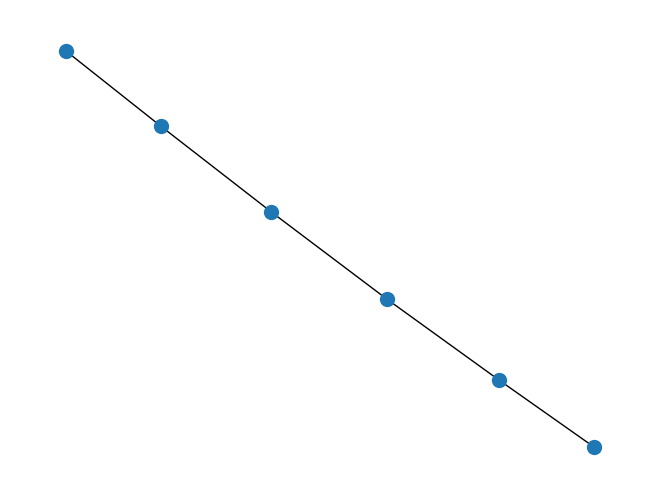

In [21]:
graph_draw(graph_dict_ind[class0_smile])

Explanation graph for class 1

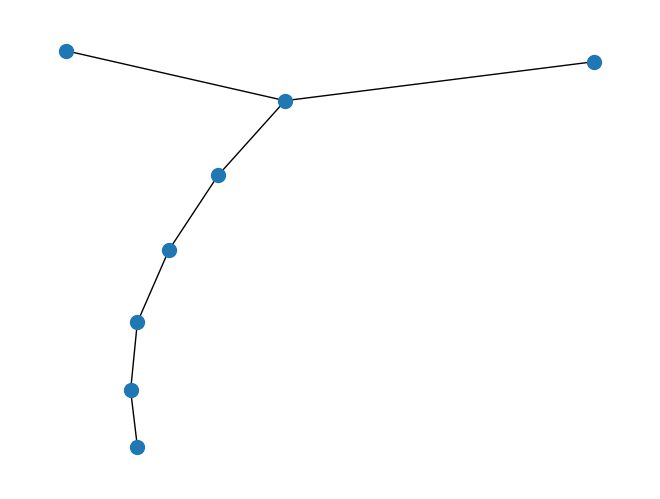

In [22]:
graph_draw(graph_dict_ind[class1_smile])

In [23]:
motifs_path = '../motifs/mutag/'
#files_motif = os.listdir(motifs_path)

In [24]:
from os import walk
w = walk(motifs_path)

for (dirpath, dirnames, filenames) in w:
    print(dirpath,filenames)

motifs/mutag/ []
motifs/mutag/class0 ['motif_real_mutag_21.gexf', 'motif_real_mutag_22.gexf', 'motif_real_mutag_23.gexf', 'motif_real_mutag_24.gexf', 'motif_real_mutag_25.gexf', 'motif_real_mutag_26.gexf', 'motif_real_mutag_27.gexf', 'motif_real_mutag_28.gexf', 'motif_real_mutag_29.gexf', 'motif_real_mutag_3.gexf', 'motif_real_mutag_30.gexf', 'motif_real_mutag_31.gexf', 'motif_real_mutag_32.gexf', 'motif_real_mutag_33.gexf', 'motif_real_mutag_34.gexf', 'motif_real_mutag_35.gexf', 'motif_real_mutag_36.gexf', 'motif_real_mutag_37.gexf', 'motif_real_mutag_38.gexf', 'motif_real_mutag_39.gexf', 'motif_real_mutag_4.gexf', 'motif_real_mutag_40.gexf', 'motif_real_mutag_41.gexf', 'motif_real_mutag_42.gexf', 'motif_real_mutag_43.gexf', 'motif_real_mutag_5.gexf', 'motif_real_mutag_6.gexf', 'motif_real_mutag_7.gexf', 'motif_real_mutag_8.gexf', 'motif_real_mutag_9.gexf', 'motif_real_mutag_0.gexf', 'motif_real_mutag_1.gexf', 'motif_real_mutag_10.gexf', 'motif_real_mutag_11.gexf', 'motif_real_mutag_1

In [25]:
def get_faithfulness(graph_list):
    class_faithfulness = []
    for i, g in enumerate(graph_list):
        expln_graph = torch_geometric.utils.to_networkx(g, to_undirected=True)
        faith_score_list = []
        path = motifs_path + 'class' + str(i) + '/'
        files_motif = os.listdir(path)
        for index_m, file_m in enumerate(files_motif):
            filepath_m = os.path.join(path, file_m)
            
            motif_graph = nx.read_gexf(filepath_m)

            GM = nx.algorithms.isomorphism.GraphMatcher(expln_graph,motif_graph)
            x = 1 if GM.subgraph_is_isomorphic() else 0    
            faith_score_list.append(x)

        class_faithfulness.append(np.mean(faith_score_list))

    return np.mean(class_faithfulness)

In [26]:
faithfulness_list = []

for i in range(0,10):
    faithfulness = get_faithfulness(class_graph_list[i])

    print('Run'+str(i),faithfulness)
    faithfulness_list.append(faithfulness)
print(np.mean(faithfulness_list))

Run0 0.4253246753246753
Run1 0.4253246753246753
Run2 0.4253246753246753
Run3 0.4253246753246753
Run4 0.4253246753246753
Run5 0.4253246753246753
Run6 0.4253246753246753
Run7 0.4253246753246753
Run8 0.4253246753246753
Run9 0.4253246753246753
0.42532467532467527
